In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
from utilities import *

In [3]:
import joblib
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from scipy.stats import boxcox
from rfpimp import plot_corr_heatmap
from rfpimp import permutation_importances
import eli5
from eli5.sklearn import PermutationImportance
from treeinterpreter import treeinterpreter as ti, utils
import lime
import lime.lime_tabular
import seaborn as sns

sns.set()

Using TensorFlow backend.


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

## Import Data

In [6]:
pin = read_pin('../Data/pin.csv')
test_pin = read_pin('../Data/testPin.csv')
ble = read_ble('../Data/ble.csv')

In [7]:
data_1 = read_data('../Data/rssi5.csv')
data_2 = read_data('../Data/rssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [8]:
test_1 = read_data('../Data/testRssi.csv')
test_2 = read_data('../Data/testRssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [9]:
data = pd.concat([data_1, data_2], axis=0)
test = pd.concat([test_1, test_2], axis=0)

In [10]:
test.shape

(27229, 19)

## Train Validation Split

In [11]:
train, validation = train_validation_split(data)

In [12]:
print(train.shape)
print(validation.shape)

(102033, 19)
(11337, 19)


In [13]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

def impute(data):
    rolling_win = 30

    data = data.sort_values("time")
    data_rolled = data.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    data_imputed = data_rolled.set_index("location").groupby("location").ffill()
    data_imputed.reset_index(inplace=True)
    data_imputed["X"] = data_imputed["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data_imputed["Y"] = data_imputed["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    linear_impute(data_imputed)
    return data_imputed

In [14]:
train_imputed = impute(train)
validation_imputed = impute(validation)
test_imputed = impute(test)

In [15]:
train_imputed[scanners] = normalize(train_imputed[scanners] + 100)
validation_imputed[scanners] = normalize(validation_imputed[scanners] + 100)
test_imputed[scanners] = normalize(test_imputed[scanners] + 100)

In [16]:
train_imputed

location  level_1  C400A2E19293  CD4533FFC0E1  D2B6503554D7  \
0         V1_10    30171      0.270859      0.233392      0.211301   
1         V1_10    30172      0.269998      0.232650      0.210630   
2         V1_10    30173      0.323051      0.228668      0.207025   
3         V1_10    30176      0.322614      0.228359      0.206745   
4         V1_10    30177      0.323185      0.228763      0.207111   
...         ...      ...           ...           ...           ...   
102028     V1_9    31037      0.272912      0.159663      0.211646   
102029     V1_9    31039      0.275097      0.160941      0.213341   
102030     V1_9    31040      0.275097      0.140356      0.213341   
102031     V1_9    31042      0.273806      0.139697      0.212339   
102032     V1_9    31043      0.242039      0.139638      0.212250   

        DB8B36A69C56  DD697EA75B68  DF231643E227  E13B805C6CB0  E43355CA8B96  \
0           0.353549      0.281666      0.193480      0.167370      0.284954   
1           0.352425      0.280771      0.192865      0.184881      0.284048   
2           0.346393      0.275966      0.189564      0.181716      0.279187   
3           0.345925      0.275592      0.189307      0.181471      0.278809   
4           0.346537      0.276080      0.189643      0.181792      0.279303   
...              ...           ...           ...           ...           ...   
102028      0.328608      0.167089      0.100253      0.222785      0.412153   
102029      0.312151      0.168427      0.101056      0.224569      0.415453   
102030      0.312151      0.168427      0.123513      0.224569      0.415453   
102031      0.310686      0.167636      0.122933      0.223515      0.424679   
102032      0.310555      0.167566      0.122882      0.223421      0.424500   

        ...  E8FD0B453DC4  E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  \
0       ...      0.207280      0.113343      0.307202      0.356753   
1       ...      0.206622      0.112983      0.306226      0.355619   
2       ...      0.203085      0.111049      0.300985      0.349533   
3       ...      0.202811      0.110899      0.300577      0.352859   
4       ...      0.203170      0.111095      0.301110      0.348434   
...     ...           ...           ...           ...           ...   
102028  ...      0.200507      0.100253      0.306330      0.263629   
102029  ...      0.202112      0.101056      0.308783      0.265740   
102030  ...      0.202112      0.101056      0.310654      0.265740   
102031  ...      0.201164      0.100582      0.309196      0.264493   
102032  ...      0.201079      0.100539      0.309066      0.264381   

        F1EDAF28E08A  F69A86823B96  FB2EE01C18CE  FDAE5980F28C         X  \
0           0.255005      0.218772      0.043828      0.278136  11.17660   
1           0.254194      0.218076      0.043688      0.277252  11.17660   
2           0.249844      0.214344      0.042941      0.272507  11.17660   
3           0.249506      0.214054      0.042883      0.272206  11.17660   
4           0.249948      0.214433      0.042959      0.272688  11.17660   
...              ...           ...           ...           ...       ...   
102028      0.303545      0.206076      0.066836      0.367595   8.17867   
102029      0.305976      0.198370      0.067371      0.370539   8.17867   
102030      0.305976      0.198370      0.067371      0.370539   8.17867   
102031      0.304539      0.197438      0.067055      0.368800   8.17867   
102032      0.331408      0.197355      0.067026      0.368645   8.17867   

              Y  
0       5.29753  
1       5.29753  
2       5.29753  
3       5.29753  
4       5.29753  
...         ...  
102028  5.28213  
102029  5.28213  
102030  5.28213  
102031  5.28213  
102032  5.28213  

[102033 rows x 21 columns]

In [17]:
X_train, y_train = train_imputed[scanners].copy(), train_imputed[["X", "Y"]].copy()
X_validation, y_validation = validation_imputed[scanners].copy(), validation_imputed[["X", "Y"]].copy()
X_test, y_test = test_imputed[scanners].copy(), test_imputed[["X", "Y"]].copy()

Text(0.5, 1, 'Correlation matrix')

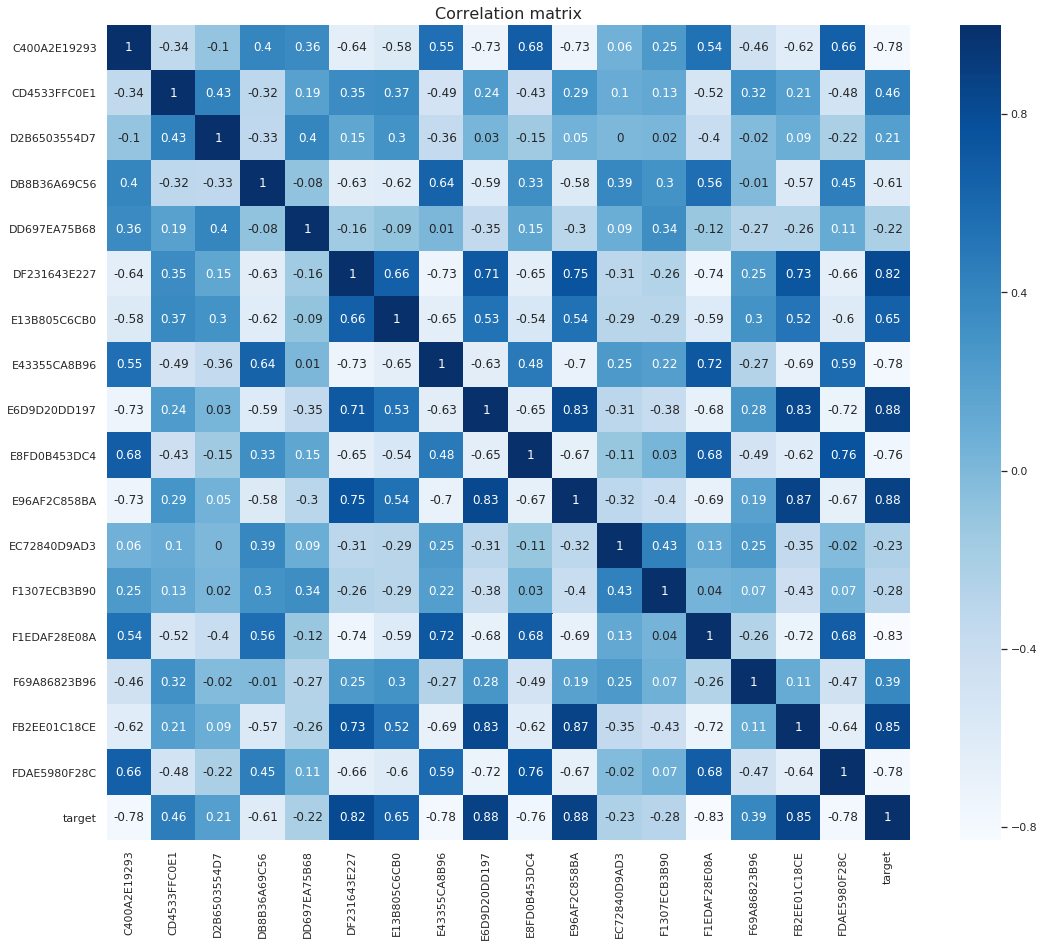

In [18]:
plt.figure(figsize=(18, 15))

sns.heatmap(
    X_train.assign(target = y_train['X']).corr().round(2), 
    cmap = 'Blues', 
    annot = True
).set_title('Correlation matrix', fontsize = 16)

## Model Training

In [19]:
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)

In [20]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [21]:
print('Training MSE: {:.2f}'.format(mean_squared_error(rf.predict(X_train), y_train)))
print('Validation MSE: {:.2f}'.format(mean_squared_error(rf.predict(X_validation), y_validation)))
print('Test MSE: {:.2f}'.format(mean_squared_error(rf.predict(X_test), y_test)))
print('OOB Score: {:.2f}'.format(rf.oob_score_))

Training MSE: 0.00
Validation MSE: 0.25
Test MSE: 3.92
OOB Score: 1.00


## Default Scikit-Learn's Feature Importances

In [22]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp

feature  feature_importance
0   E6D9D20DD197            0.634930
1   E96AF2C858BA            0.089429
2   CD4533FFC0E1            0.083881
3   F69A86823B96            0.044728
4   E8FD0B453DC4            0.035245
5   F1EDAF28E08A            0.029793
6   E13B805C6CB0            0.024060
7   D2B6503554D7            0.015482
8   FB2EE01C18CE            0.008327
9   C400A2E19293            0.007457
10  E43355CA8B96            0.007139
11  EC72840D9AD3            0.006778
12  F1307ECB3B90            0.004296
13  DB8B36A69C56            0.003804
14  DD697EA75B68            0.003338
15  FDAE5980F28C            0.000706
16  DF231643E227            0.000605

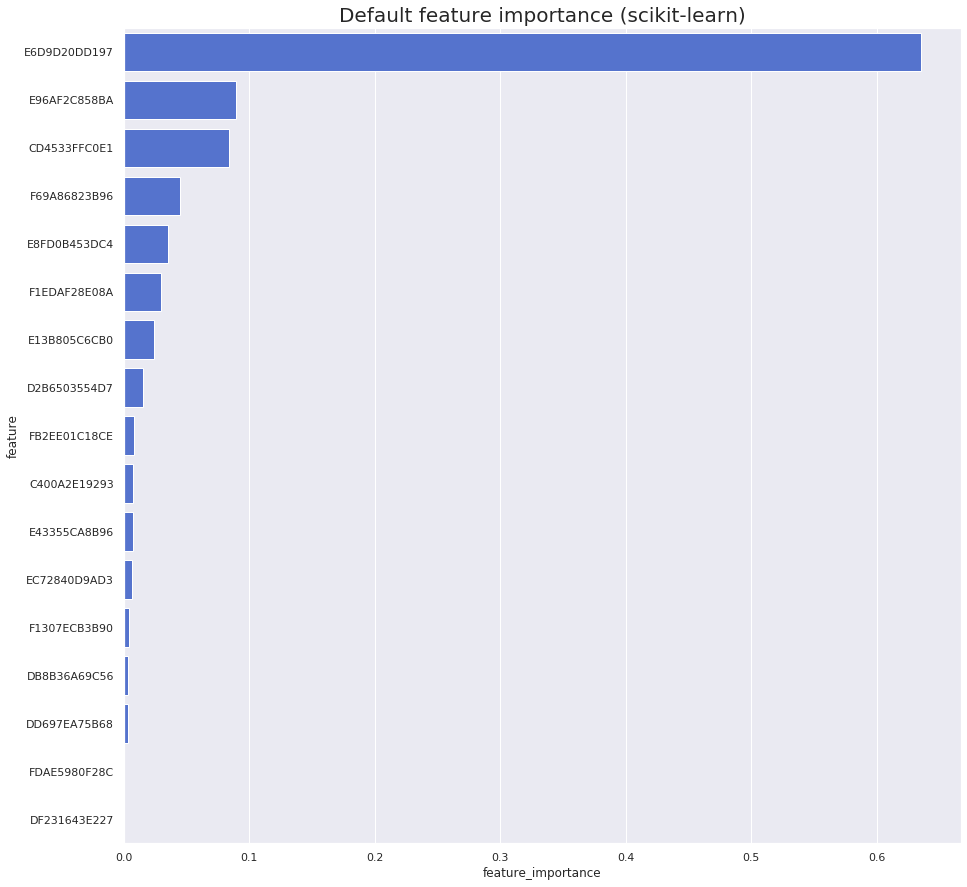

In [23]:
plt.figure(figsize=(15, 15))
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

In [24]:
train.describe()

C400A2E19293  CD4533FFC0E1  D2B6503554D7  DB8B36A69C56  DD697EA75B68  \
count   6153.000000   5991.000000   4952.000000   7094.000000   6117.000000   
mean     -73.210629    -74.909865    -77.493134    -72.800677    -72.838810   
std        8.595851      7.296137      6.954824      8.785668      6.760611   
min      -97.000000    -98.000000    -98.000000    -98.000000    -97.000000   
25%      -79.000000    -80.000000    -82.000000    -79.000000    -77.000000   
50%      -72.000000    -74.000000    -77.000000    -72.000000    -72.000000   
75%      -68.000000    -69.000000    -72.000000    -65.000000    -67.000000   
max      -56.000000    -63.000000    -61.000000    -56.000000    -59.000000   

       DF231643E227  E13B805C6CB0  E43355CA8B96  E6D9D20DD197  E8FD0B453DC4  \
count   7138.000000   7220.000000   6987.000000  10339.000000   4351.000000   
mean     -73.958112    -74.835596    -74.062258    -76.211723    -77.843254   
std        8.669548      9.188261      8.782041     11.723195      9.894839   
min      -98.000000    -98.000000    -98.000000    -98.000000    -98.000000   
25%      -80.000000    -82.000000    -81.000000    -85.000000    -85.000000   
50%      -73.000000    -75.000000    -73.000000    -77.000000    -78.000000   
75%      -66.000000    -68.000000    -68.000000    -69.000000    -70.000000   
max      -55.000000    -53.000000    -56.000000    -49.000000    -58.000000   

       E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
count   7320.000000   6304.000000   8021.000000   8007.000000   7908.000000   
mean     -76.246585    -72.074714    -68.832315    -76.452479    -74.213075   
std       10.249757      7.526966      7.858517      9.380843      8.522773   
min      -98.000000    -97.000000    -96.000000    -98.000000    -98.000000   
25%      -85.000000    -77.000000    -74.000000    -84.000000    -80.000000   
50%      -75.000000    -72.000000    -67.000000    -75.000000    -75.000000   
75%      -67.000000    -66.000000    -63.000000    -69.000000    -68.000000   
max      -52.000000    -55.000000    -54.000000    -57.000000    -55.000000   

       FB2EE01C18CE  FDAE5980F28C  
count   4410.000000   6172.000000  
mean     -82.028345    -75.125081  
std        8.548097      8.136609  
min      -98.000000    -98.000000  
25%      -90.000000    -81.000000  
50%      -83.000000    -74.000000  
75%      -74.000000    -69.000000  
max      -67.000000    -59.000000

## Permutation Feature Importance

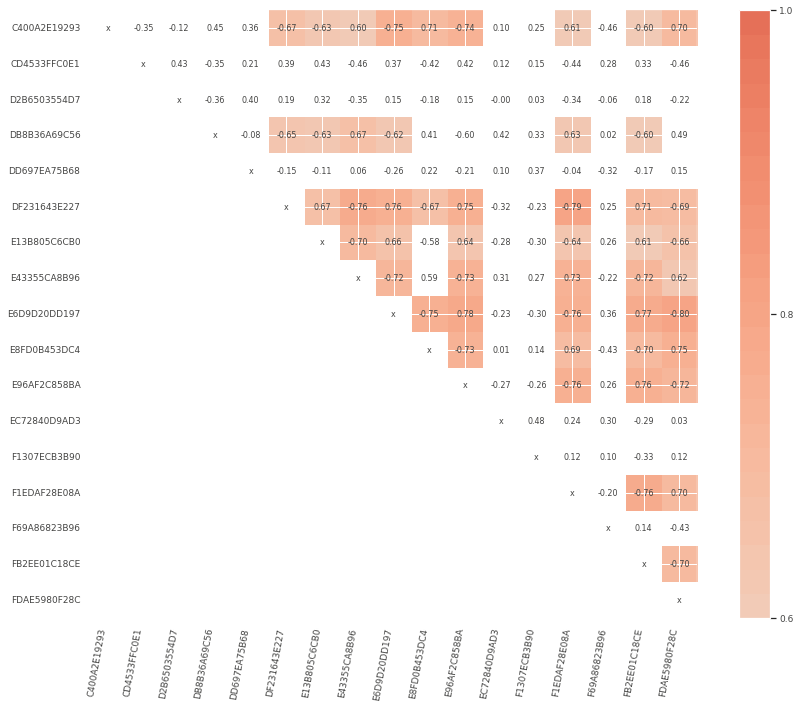

In [25]:
viz = plot_corr_heatmap(X_train, figsize=(15,10))
viz.view()

In [26]:
def mse(rf, X_train, y_train):
    return mean_squared_error(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, mse)
perm_imp_rfpimp.reset_index(drop=False, inplace=True)

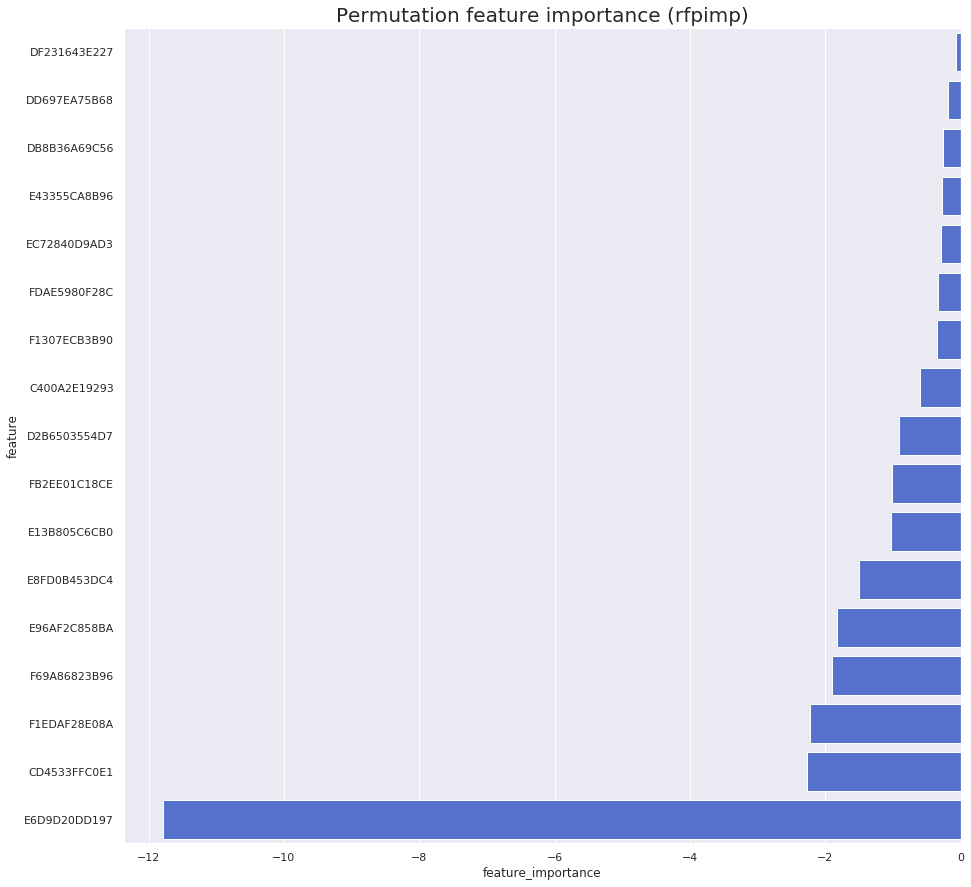

In [27]:
plt.figure(figsize=(15, 15))
var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

In [28]:
perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

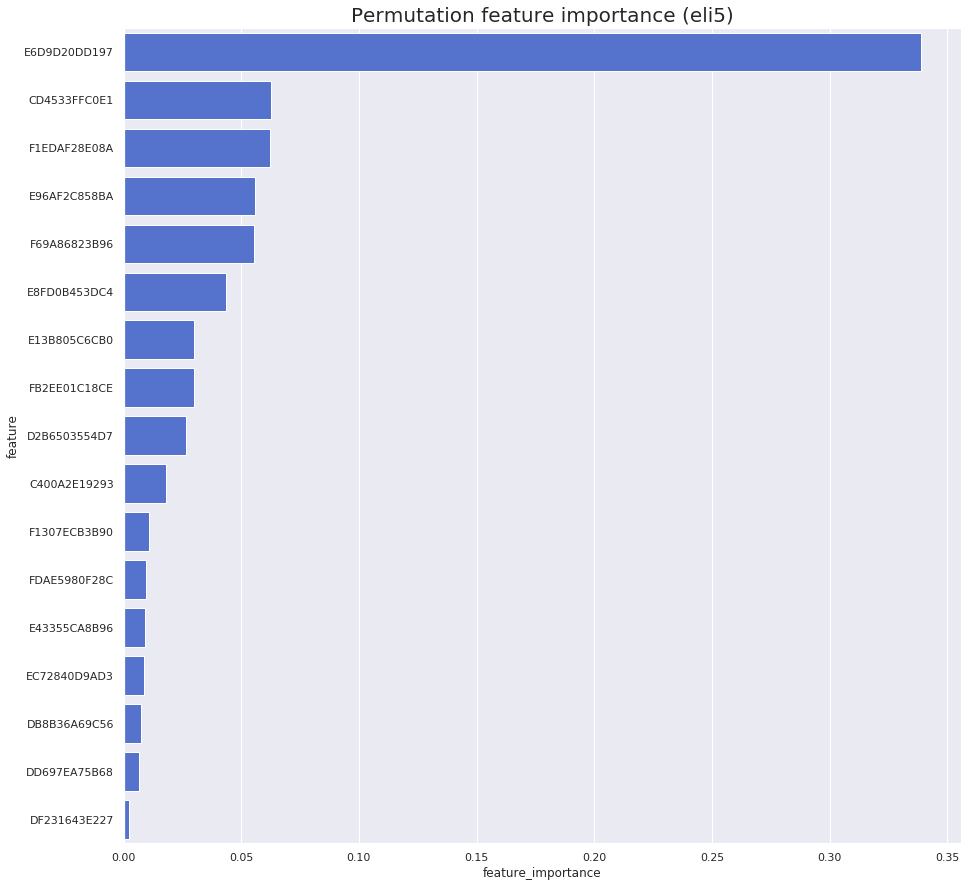

In [29]:
plt.figure(figsize=(15, 15))
var_imp_plot(perm_imp_eli5, 'Permutation feature importance (eli5)')

In [30]:
eli5.show_weights(perm)

## Drop Column Feature Importance

In [31]:
def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [32]:
drop_imp = drop_col_feat_imp(rf, X_train, y_train)

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/mimos/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses 

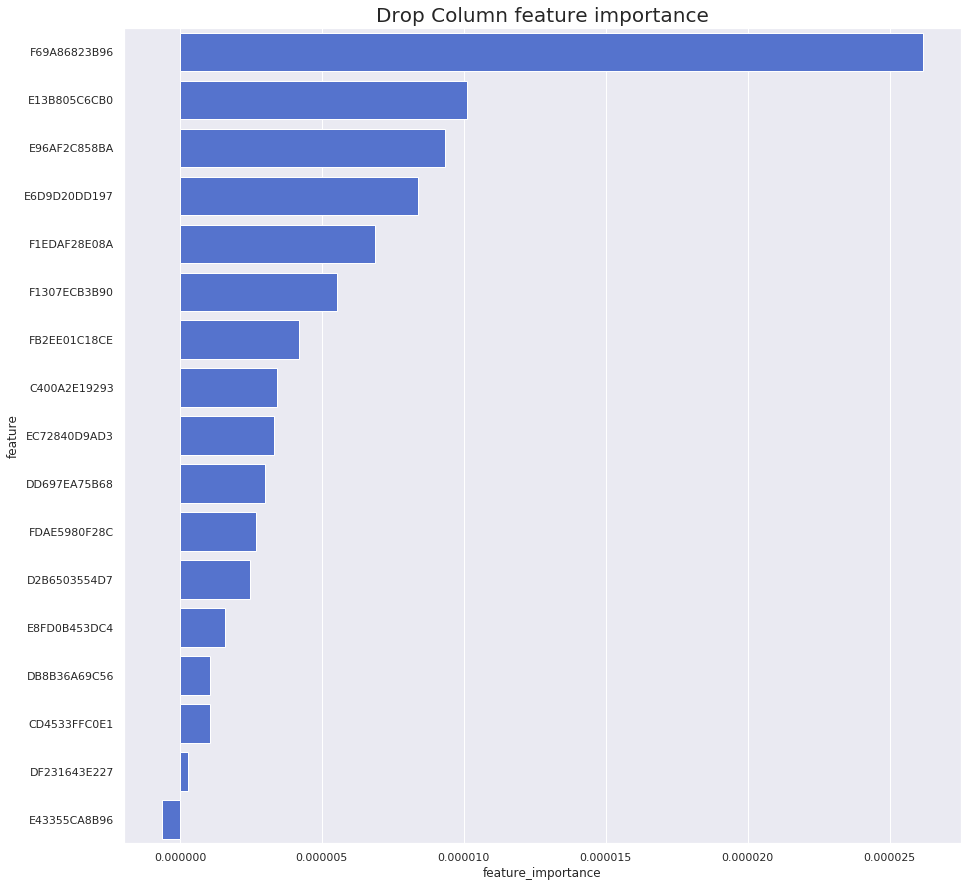

In [33]:
plt.figure(figsize=(15, 15))
var_imp_plot(drop_imp, 'Drop Column feature importance')

## Treeinterpreter

Create each Random Forest for x and y coordinates because multilabel classification trees not supported

In [34]:
rf_x = RandomForestRegressor(
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)

rf_x.fit(X_train, y_train['X'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [35]:
rf_y = RandomForestRegressor(
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)

rf_y.fit(X_train, y_train['Y'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [36]:
print('Training MSE: {:.2f}'.format(mean_squared_error(rf_x.predict(X_train), y_train['X'])))
print('Validation MSE: {:.2f}'.format(mean_squared_error(rf_x.predict(X_validation), y_validation['X'])))
print('Test MSE: {:.2f}'.format(mean_squared_error(rf_x.predict(X_test), y_test['X'])))
print('OOB Score: {:.2f}'.format(rf_x.oob_score_))

Training MSE: 0.00
Validation MSE: 0.44
Test MSE: 4.26
OOB Score: 1.00


In [37]:
print('Training MSE: {:.2f}'.format(mean_squared_error(rf_y.predict(X_train), y_train['Y'])))
print('Validation MSE: {:.2f}'.format(mean_squared_error(rf_y.predict(X_validation), y_validation['Y'])))
print('Test MSE: {:.2f}'.format(mean_squared_error(rf_y.predict(X_test), y_test['Y'])))
print('OOB Score: {:.2f}'.format(rf_y.oob_score_))

Training MSE: 0.00
Validation MSE: 0.24
Test MSE: 3.46
OOB Score: 1.00


In [38]:
pred_diff = pd.DataFrame({
    'x_diff': abs(y_train['X'] - rf_x.predict(X_train)),
})

x_smallest = pred_diff.sort_values('x_diff').head(1).index.values[0]
x_largest = pred_diff.sort_values('x_diff', ascending = False).head(1).index.values[0]
print('Index with smallest error:', x_smallest)
print('Index with largest error:', x_largest)

Index with smallest error: 45659
Index with largest error: 99537


In [39]:
pred_diff = pd.DataFrame({
    'y_diff': abs(y_train['Y'] - rf_y.predict(X_train)),
})

y_smallest = pred_diff.sort_values('y_diff').head(1).index.values[0]
y_largest = pred_diff.sort_values('y_diff', ascending = False).head(1).index.values[0]
print('Index with smallest error:', y_smallest)
print('Index with largest error:', y_largest)

Index with smallest error: 26684
Index with largest error: 67107


In [40]:
selected_rows = [x_smallest, x_largest]
selected_df = X_train.iloc[selected_rows,:].values
prediction, bias, contributions = ti.predict(rf_x, selected_df)

for i in range(len(selected_rows)):
    print("Row", selected_rows[i])
    print("Prediction:", prediction[i][0], 'Actual Value:', y_train.iloc[selected_rows[i]]['X'])
    print("Bias (trainset mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 X_train.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20)

Row 45659
Prediction: 23.1537 Actual Value: 23.1537
Bias (trainset mean) 16.823689370835726
Feature contributions:
E6D9D20DD197 7.24
E96AF2C858BA -3.16
E13B805C6CB0 2.03
D2B6503554D7 0.12
E8FD0B453DC4 0.04
CD4533FFC0E1 0.02
FDAE5980F28C 0.02
F69A86823B96 -0.02
DD697EA75B68 0.01
C400A2E19293 0.01
F1EDAF28E08A 0.01
F1307ECB3B90 0.01
E43355CA8B96 0.0
EC72840D9AD3 0.0
DF231643E227 -0.0
DB8B36A69C56 0.0
FB2EE01C18CE 0.0
--------------------
Row 99537
Prediction: 10.849391900000024 Actual Value: 8.17867
Bias (trainset mean) 16.823689370835726
Feature contributions:
E6D9D20DD197 6.06
E96AF2C858BA -3.26
E8FD0B453DC4 -3.0
FDAE5980F28C -1.85
F69A86823B96 -1.81
E13B805C6CB0 -1.25
DD697EA75B68 1.22
E43355CA8B96 -0.87
DB8B36A69C56 -0.4
CD4533FFC0E1 -0.38
EC72840D9AD3 0.34
F1307ECB3B90 -0.32
DF231643E227 -0.2
D2B6503554D7 -0.19
F1EDAF28E08A -0.05
C400A2E19293 -0.01
FB2EE01C18CE -0.0
--------------------


In [41]:
prediction1, bias1, contributions1 = ti.predict(rf_x, np.array([selected_df[0]]), joint_contribution=True)
prediction2, bias2, contributions2 = ti.predict(rf_x, np.array([selected_df[1]]), joint_contribution=True)

In [42]:
aggregated_contributions1 = utils.aggregated_contribution(contributions1)
aggregated_contributions2 = utils.aggregated_contribution(contributions2)

In [43]:
res = []
for k in set(aggregated_contributions1.keys()).union(
              set(aggregated_contributions2.keys())):
    res.append(([X_train.columns[index] for index in k] , 
               aggregated_contributions1.get(k, 0) - aggregated_contributions2.get(k, 0)))   
         
for lst, v in (sorted(res, key=lambda x:-abs(x[1])))[:10]:
    print (lst, v)

['E13B805C6CB0', 'E6D9D20DD197', 'E96AF2C858BA'] [3.29516873]
['DD697EA75B68', 'E13B805C6CB0', 'E6D9D20DD197', 'E8FD0B453DC4', 'E96AF2C858BA', 'EC72840D9AD3', 'F69A86823B96'] [2.55413391]
['DD697EA75B68', 'E13B805C6CB0', 'E6D9D20DD197', 'E96AF2C858BA', 'EC72840D9AD3', 'F69A86823B96', 'FDAE5980F28C'] [1.73836058]
['E6D9D20DD197'] [1.16883665]
['E13B805C6CB0', 'E6D9D20DD197', 'E96AF2C858BA', 'F69A86823B96'] [0.54204761]
['DD697EA75B68', 'E13B805C6CB0', 'E6D9D20DD197', 'E96AF2C858BA', 'EC72840D9AD3', 'F69A86823B96'] [-0.41424607]
['DD697EA75B68', 'E13B805C6CB0', 'E43355CA8B96', 'E6D9D20DD197', 'E96AF2C858BA', 'F69A86823B96'] [0.38849112]
['E6D9D20DD197', 'E96AF2C858BA'] [-0.28661258]
['DD697EA75B68', 'E13B805C6CB0', 'E6D9D20DD197', 'E96AF2C858BA', 'F69A86823B96'] [0.26851076]
['DD697EA75B68', 'E13B805C6CB0', 'E6D9D20DD197', 'E96AF2C858BA', 'F69A86823B96', 'FDAE5980F28C'] [0.21518837]


In [44]:
selected_rows = [y_smallest, y_largest]
selected_df = X_train.iloc[selected_rows,:].values
prediction, bias, contributions = ti.predict(rf_y, selected_df)

for i in range(len(selected_rows)):
    print("Row", selected_rows[i])
    print("Prediction:", prediction[i][0], 'Actual Value:', y_train.iloc[selected_rows[i]]['Y'])
    print("Bias (trainset mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 X_train.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20)

Row 26684
Prediction: 8.27409 Actual Value: 8.27409
Bias (trainset mean) 8.361160612831954
Feature contributions:
D2B6503554D7 3.78
E43355CA8B96 -3.1
F69A86823B96 2.23
F1EDAF28E08A -1.49
FDAE5980F28C -0.7
C400A2E19293 -0.46
E8FD0B453DC4 -0.15
CD4533FFC0E1 -0.12
FB2EE01C18CE -0.08
DB8B36A69C56 0.0
DD697EA75B68 0.0
DF231643E227 0.0
E13B805C6CB0 0.0
E6D9D20DD197 0.0
E96AF2C858BA 0.0
EC72840D9AD3 0.0
F1307ECB3B90 0.0
--------------------
Row 67107
Prediction: 10.67084860000001 Actual Value: 12.1864
Bias (trainset mean) 8.361160612831954
Feature contributions:
E8FD0B453DC4 2.45
F1307ECB3B90 -2.27
DB8B36A69C56 -2.0
FDAE5980F28C 1.93
F69A86823B96 1.64
E43355CA8B96 0.9
EC72840D9AD3 0.82
E6D9D20DD197 -0.61
C400A2E19293 -0.54
F1EDAF28E08A -0.02
CD4533FFC0E1 0.02
DD697EA75B68 -0.0
DF231643E227 -0.0
D2B6503554D7 -0.0
E96AF2C858BA -0.0
E13B805C6CB0 0.0
FB2EE01C18CE 0.0
--------------------


In [45]:
prediction1, bias1, contributions1 = ti.predict(rf_x, np.array([selected_df[0]]), joint_contribution=True)
prediction2, bias2, contributions2 = ti.predict(rf_x, np.array([selected_df[1]]), joint_contribution=True)

In [46]:
aggregated_contributions1 = utils.aggregated_contribution(contributions1)
aggregated_contributions2 = utils.aggregated_contribution(contributions2)

In [47]:
res = []
for k in set(aggregated_contributions1.keys()).union(
              set(aggregated_contributions2.keys())):
    res.append(([X_train.columns[index] for index in k] , 
               aggregated_contributions1.get(k, 0) - aggregated_contributions2.get(k, 0)))   
         
for lst, v in (sorted(res, key=lambda x:-abs(x[1])))[:10]:
    print (lst, v)

['CD4533FFC0E1', 'E6D9D20DD197', 'F1EDAF28E08A'] [-4.48036408]
['CD4533FFC0E1', 'E6D9D20DD197', 'F1EDAF28E08A', 'F69A86823B96'] [0.48809062]
['CD4533FFC0E1', 'E43355CA8B96', 'E6D9D20DD197', 'F1EDAF28E08A', 'F69A86823B96'] [-0.48552264]
['CD4533FFC0E1', 'E6D9D20DD197', 'F1EDAF28E08A', 'FB2EE01C18CE'] [0.37001819]
['CD4533FFC0E1', 'D2B6503554D7', 'E43355CA8B96', 'E6D9D20DD197', 'F1EDAF28E08A', 'F69A86823B96'] [0.2575675]
['CD4533FFC0E1', 'DB8B36A69C56', 'E6D9D20DD197', 'F1307ECB3B90', 'F1EDAF28E08A', 'F69A86823B96', 'FB2EE01C18CE'] [-0.08710711]
['CD4533FFC0E1', 'DB8B36A69C56', 'E6D9D20DD197', 'F1EDAF28E08A', 'FB2EE01C18CE'] [-0.0540546]
['CD4533FFC0E1', 'D2B6503554D7', 'E43355CA8B96', 'E6D9D20DD197', 'E96AF2C858BA', 'F1EDAF28E08A', 'F69A86823B96'] [0.04897923]
['CD4533FFC0E1', 'DB8B36A69C56', 'E6D9D20DD197', 'F1307ECB3B90', 'F1EDAF28E08A', 'FB2EE01C18CE'] [-0.03123057]
['CD4533FFC0E1', 'E6D9D20DD197', 'F1307ECB3B90', 'F1EDAF28E08A', 'FB2EE01C18CE'] [-0.02938828]


## LIME

In [48]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode = 'regression',
    feature_names = X_train.columns,
    categorical_features=[3], 
    categorical_names=['CHAS'], 
    discretize_continuous = True
)

In [49]:
np.random.seed(42)
exp = explainer.explain_instance(X_train.values[x_smallest], rf.predict, num_features=5)
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed

np.random.seed(42)
exp = explainer.explain_instance(X_train.values[x_largest], rf.predict, num_features=5)
exp.show_in_notebook(show_all=False)